### Studying correlation of fire spot counts and sum of previous precipitation volume

In [1]:
# importing dependencies

import s3fs
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import duckdb
import json

from datetime import datetime

In [2]:
# defining matplotlib theme
plt.style.use('ggplot')
# setting up the duckdb
conn = duckdb.connect()

In [3]:
# loading s3 configurations
airflow_conns = json.load(open('../connections.json'))
fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": airflow_conns['aws_s3_conn_id']['host'],
        "aws_access_key_id": airflow_conns['aws_s3_conn_id']['login'],
        "aws_secret_access_key": airflow_conns['aws_s3_conn_id']['password'],
    }
)

#### Loading tables
- GHCN
- FIRMS

In [7]:
# defining ghcn columns
columns = ['adm_name', 'value', 'distance_from_station', 'datetime']
# looking for data from stations inside the administrative area
filters = [('distance_from_station', '=', 0)]
ghcn = pq.read_table("dutrajardim-fi/tables/ghcn/osm_adm8.parquet/element=PRCP/year=2021", filesystem=fs, columns=columns, filters=filters)

# defining firms columns
columns = ['adm_name', 'datetime']
firms = pq.read_table("dutrajardim-fi/tables/firms/osm_adm8.parquet/year=2021", filesystem=fs, columns=columns)

In [8]:
# defining function to format chart ticks
def x_fmt_func(labels):
    return ticker.FuncFormatter(lambda x, y: datetime.strptime(labels[x][:2], "%m").strftime("%b") + labels[x][2:])

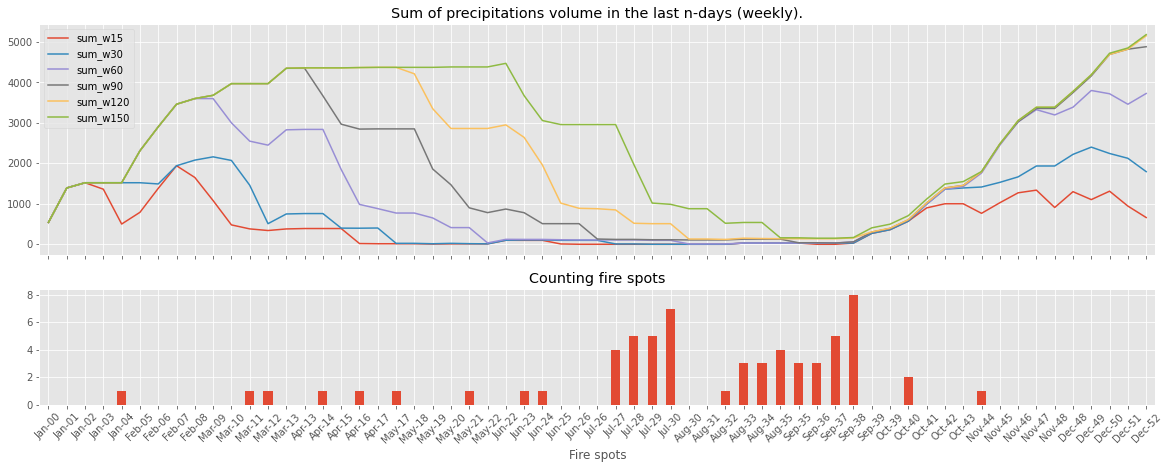

In [20]:
city = 'Belo Horizonte'
year = 2021

# counting previous sum of precipitation volume (take the maximum value reached in the week)
prcp_mv_sumation = conn.execute(f"""
SELECT week, MAX(sum_w15) as sum_w15, MAX(sum_w30) as sum_w30, MAX(sum_w60) as sum_w60, MAX(sum_w90) as sum_w90, MAX(sum_w120) as sum_w120, MAX(sum_w150) as sum_w150
FROM
    (SELECT
        days.date,
        STRFTIME(days.date, '%m-%W') AS week,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 15 DAYS PRECEDING) AS sum_w15,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 30 DAYS PRECEDING) AS sum_w30,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 60 DAYS PRECEDING) AS sum_w60,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 90 DAYS PRECEDING) AS sum_w90,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 120 DAYS PRECEDING) AS sum_w120,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 150 DAYS PRECEDING) AS sum_w150

    FROM 

        (SELECT CAST(generate_series AS DATE) AS date
        FROM GENERATE_SERIES(TIMESTAMP '{year - 1}-11-01', TIMESTAMP '{year}-12-31', INTERVAL 1 DAYS))
        
        days

    LEFT JOIN
        
        (SELECT value, CAST(STRFTIME(datetime, '%Y-%m-%d') AS DATE) AS date
        FROM ghcn
        WHERE adm_name = '{city}')

        ghcn 

    ON ghcn.date = days.date)
WHERE date >= '{year}-01-01'
GROUP BY week
""").df()

# counting fire spots in the week
weekly_fire_spots_counting = conn.execute(f"""
SELECT COUNT(*) AS fire_spots, STRFTIME(datetime, '%m-%W') as week
FROM firms
WHERE 
    adm_name = '{city}' AND 
    YEAR(datetime) = {year}
GROUP BY week
ORDER BY week ASC
""").df()

weekly_data = conn.execute("""
SELECT 
    prcp_mv_sumation.*,
    CASE WHEN fire_spots IS NOT NULL THEN fire_spots ELSE 0 END fire_spots
FROM prcp_mv_sumation
LEFT JOIN weekly_fire_spots_counting ON prcp_mv_sumation.week = weekly_fire_spots_counting.week
ORDER BY prcp_mv_sumation.week
""").df()

fig, ax = plt.subplots(
    ncols=1, 
    nrows=2, 
    sharex=True, 
    figsize=(20, 7), 
    gridspec_kw={'height_ratios': [2, 1]}
)

weekly_data.plot(
    x='week', 
    y=["sum_w15", "sum_w30", "sum_w60", "sum_w90", "sum_w120", "sum_w150"],
    ax=ax[0], 
    title='Sum of precipitations volume in the last n-days (Belo Horizonte - Weekly).'
)
weekly_data.plot(x='week', y='fire_spots', kind='bar', ax=ax[1], legend=False, rot=45, xlabel='Fire spots', title='Counting fire spots (Belo Horizonte)')

ax[1].xaxis.set_major_formatter(x_fmt_func(weekly_data['week']))

# saving to docs folder
fig.savefig(f"../docs/images/charts/BRA_MG/correlating_fires_with_precipitation/{year}-Belo Horizonte.svg") 


In [24]:
# checking correlation values
conn.execute("""
SELECT 
    CORR(sum_w15, fire_spots) as w15_correlation,
    CORR(sum_w30, fire_spots) as w30_correlation,
    CORR(sum_w60, fire_spots) as w60_correlation,
    CORR(sum_w90, fire_spots) as w90_correlation,
    CORR(sum_w120, fire_spots) as w120_correlation,
    CORR(sum_w150, fire_spots) as w150_correlation
FROM weekly_data
""").df()

,w15_correlation,w30_correlation,w60_correlation,w90_correlation,w120_correlation,w150_correlation
0,-0.437535,-0.454875,-0.458789,-0.493996,-0.503833,-0.492398
